# Team ID: 5D15
# Sem: 5th
# Div: D
# School: School Of Computer Science Engineering
# Topic ID: 5DMACP11
# Title: Prediction Of Daily Stock Movement On the US Market
# Problem Statement: The goal of this challenge is to predict the sign of the return at the end of the day.
# 254 - Tanaya N                    - 01FE17BCS228
# 256 - Taru Vatsa              - 01FE17BCS230
# 260 - Ujjwal Kumar - 01FE17BCS234

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install catboost

     |████████████████████████████████| 63.6MB 123kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import scipy
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import *
#import XGBoost classifier and accuracy
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from sklearn.model_selection import validation_curve

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
%mkdir data
%cd /content/data/
!wget -O input_training.zip https://www.dropbox.com/s/nqbk5b4lcxfzxsi/input_training.zip?dl=0
!wget -O output_training.csv https://www.dropbox.com/s/d3wjgle3b7qtzww/output_training.csv?dl=0
!wget -O input_test.zip https://www.dropbox.com/s/9u6r1ktlwz0tpuq/input_test.zip?dl=0

/content/data
--2019-12-04 07:15:08--  https://www.dropbox.com/s/nqbk5b4lcxfzxsi/input_training.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nqbk5b4lcxfzxsi/input_training.zip [following]
--2019-12-04 07:15:08--  https://www.dropbox.com/s/raw/nqbk5b4lcxfzxsi/input_training.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44585d6649230f72785699141c.dl.dropboxusercontent.com/cd/0/inline/AtmWZPsuLC4n-cm7x2n9Cor7vy99ppxq82j8qCJ6iOA7mF1BGVr4Gt9rEAdhs6J4_oY1YVdcVX_ntPxA5TUDtcx5P6xw2jzT6wVoxrf7Rhhpew/file# [following]
--2019-12-04 07:15:09--  https://uc44585d6649230f72785699141c.dl.dropboxusercontent.com/cd/0/inline/AtmWZPsuLC4n-cm7x2n9Cor7vy99ppxq82j8qCJ6iOA7mF1BGVr4Gt9rEAdhs6J4_oY1YVdcVX_ntPxA5TUDtcx5P6xw2jz

In [ ]:
!unzip input_training.zip
!unzip input_test.zip

Archive:  input_training.zip
 extracting: input_training.csv      
Archive:  input_test.zip
 extracting: input_test.csv          


## EDA

In [ ]:
df_input = pd.read_csv('input_training.csv', sep=",")
df_output = pd.read_csv('output_training.csv', sep=",")
df_test = pd.read_csv('input_test.csv', sep=",")
df_test1= pd.read_csv('input_test.csv', sep=",")

Finding unique equity code and date?

In [ ]:
df_input[['eqt_code', 'date']].nunique()

eqt_code     680
date        1511
dtype: int64

*Analysis*

There are total 680 unique equity code and 1511 unique date in our training data

NaN percentage of all attribute in training data

In [ ]:
train_nan = (df_input.isnull().sum() / df_input.shape[0]) * 100
train_nan[train_nan > 0]

09:30:00    0.708414
09:35:00    0.501525
09:40:00    0.455907
09:45:00    0.365209
09:50:00    0.413644
              ...   
15:00:00    0.284036
15:05:00    0.281085
15:10:00    0.239761
15:15:00    0.207560
15:20:00    0.182739
Length: 71, dtype: float64

NaN percentage of all attribute in testing data

In [ ]:
test_nan = (df_test.isnull().sum() / df_test.shape[0]) * 100
test_nan[test_nan > 0]

09:30:00    0.574790
09:35:00    0.535386
09:40:00    0.373707
09:45:00    0.370267
09:50:00    0.385278
              ...   
15:00:00    0.240486
15:05:00    0.244239
15:10:00    0.208275
15:15:00    0.189512
15:20:00    0.162930
Length: 71, dtype: float64

More details of training and testing data

Missing values visulisation

In [ ]:
df_input.describe()

ID      eqt_code  ...       15:15:00       15:20:00
count  745327.000000  7.453270e+05  ...  743780.000000  743965.000000
mean   372663.000000  2.096091e+09  ...      -0.000196       0.000349
std    215157.516379  1.253347e+09  ...       0.396585       0.396521
min         0.000000  3.667330e+06  ...     -15.165875     -14.854894
25%    186331.500000  1.047929e+09  ...      -0.210395      -0.211953
50%    372663.000000  2.002627e+09  ...      -0.001699      -0.001535
75%    558994.500000  3.195928e+09  ...       0.208668       0.209761
max    745326.000000  4.283129e+09  ...      28.411473      24.544605

[8 rows x 74 columns]

In [ ]:
df_test.describe()

ID      eqt_code  ...       15:15:00       15:20:00
count  3.197690e+05  3.197690e+05  ...  319163.000000  319248.000000
mean   9.052110e+05  2.095940e+09  ...      -0.000731       0.000989
std    9.230950e+04  1.252960e+09  ...       0.404566       0.391679
min    7.453270e+05  3.667330e+06  ...      -9.915366     -13.199368
25%    8.252690e+05  1.047929e+09  ...      -0.213311      -0.209634
50%    9.052110e+05  2.002627e+09  ...      -0.002147      -0.000579
75%    9.851530e+05  3.195928e+09  ...       0.210350       0.210243
max    1.065095e+06  4.283129e+09  ...      58.639122      17.585892

[8 rows x 74 columns]

*Analysis*

Std. deviation,1st quartile,2nd quartile,3rd quartile of both training nad testing data are almost similar.So,we can say that aur training and testing data have same nature.

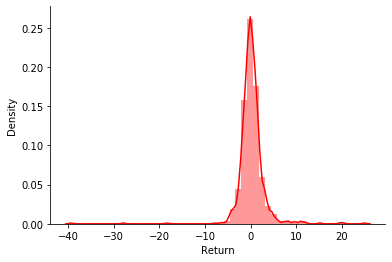

In [ ]:
sns.distplot(df_input.loc[:1000,'09:30:00'].dropna(),color='Red')
plt.xlabel('Return')
plt.ylabel('Density')
sns.despine()

*Analysis*

For a particular timestamp return value of first 1000 tuples is more concentrated to zero.

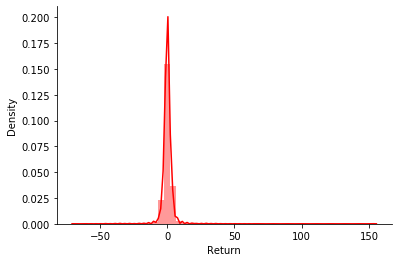

In [ ]:
sns.distplot(df_input.loc[:10000,'09:30:00'].dropna(),color='Red')
plt.xlabel('Return')
plt.ylabel('Density')
sns.despine()

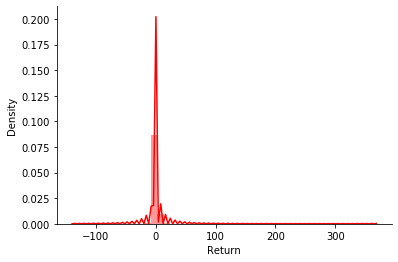

In [ ]:
sns.distplot(df_input.loc[:100000,'09:30:00'].dropna(),color='Red')
plt.xlabel('Return')
plt.ylabel('Density')
sns.despine()

*Analysis*

As the no of tuples are increasing the return value is getting more concentrated to zero

## Correleation matrix

In [ ]:
train_corr =df_input.corr()
train_corr.style.background_gradient(sns.diverging_palette(220, 10, as_cmap=True), axis=1)

Feature coreleation visualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22a827af98>,
      dtype=object)

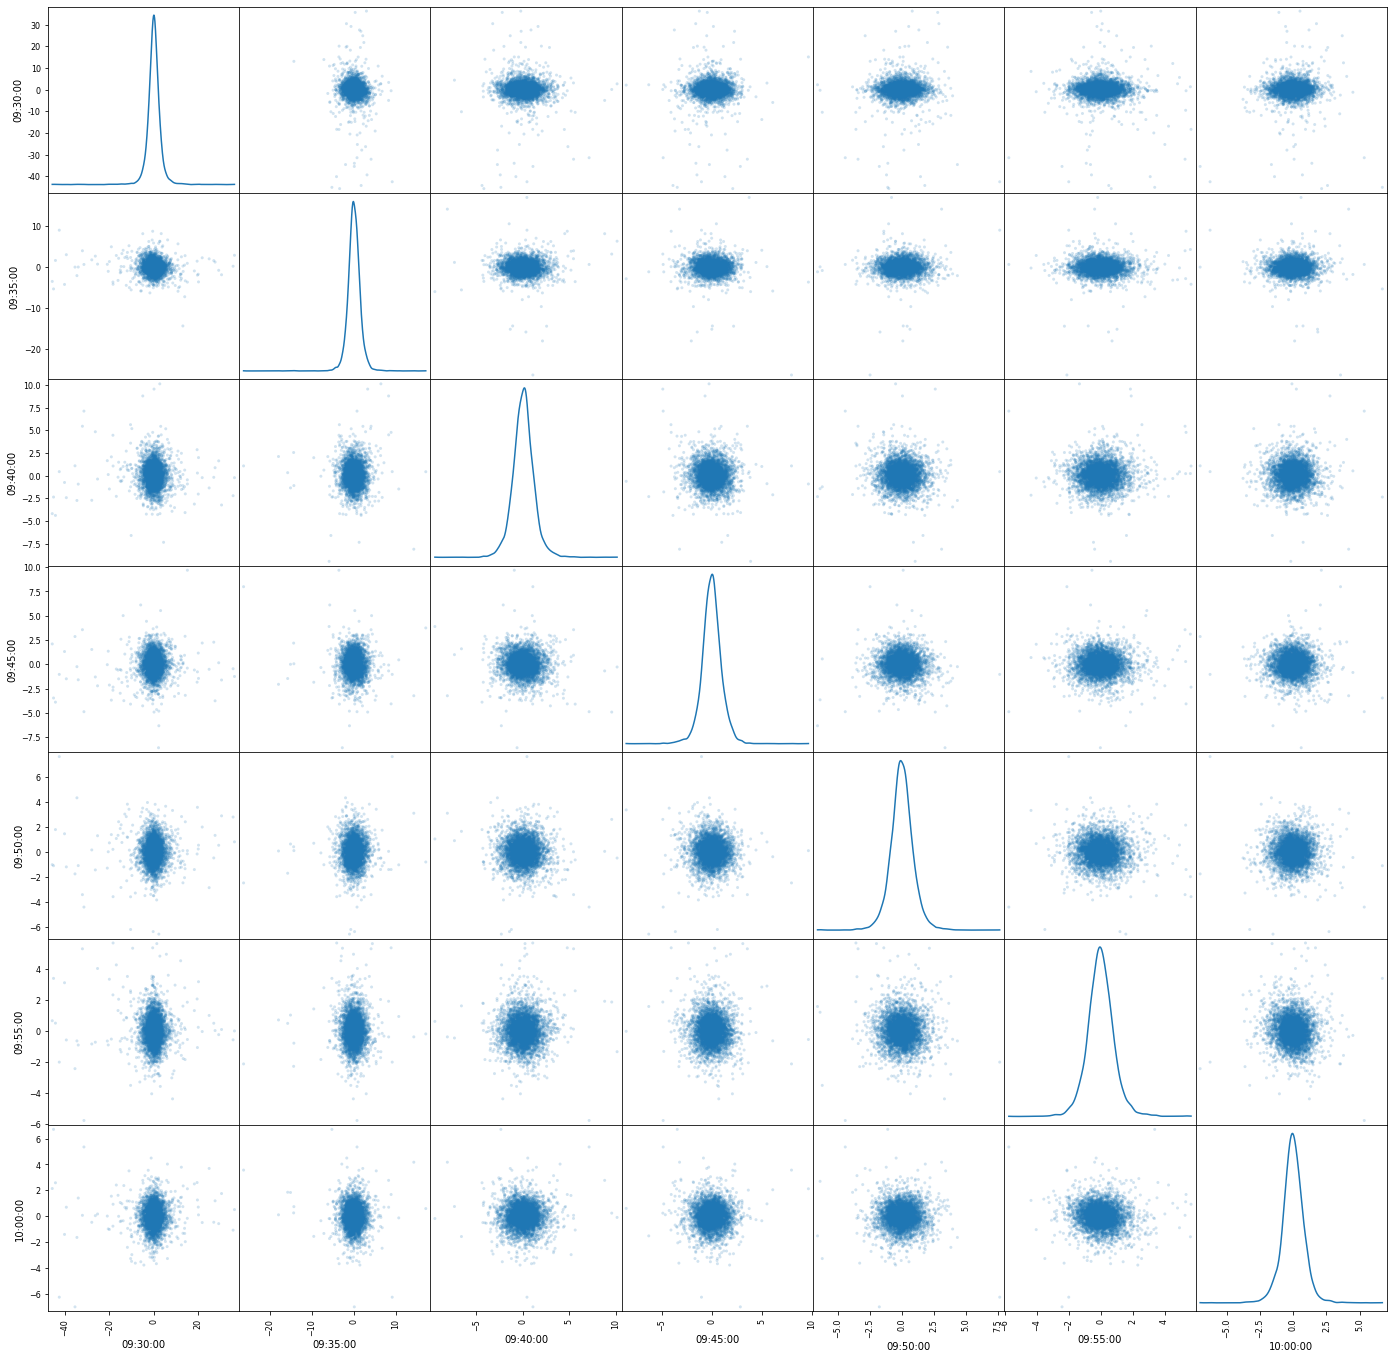

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_input.iloc[:5000,3:10], alpha=0.2, figsize=(24,24), diagonal='kde')

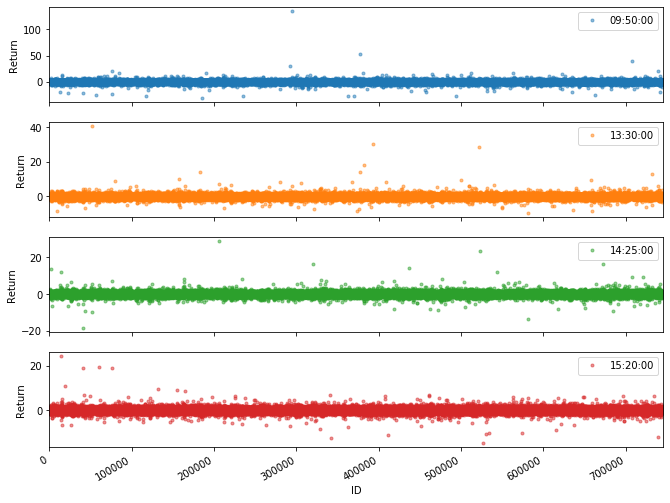

In [ ]:
cols_plot = ['09:50:00', '13:30:00', '14:25:00','15:20:00']
axes = df_input[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Return')
    ax.set_xlabel('ID')

*Analysis*

All return value are more concentrated towards zero except opening and closing time.

Text(0, 0.5, 'Return')

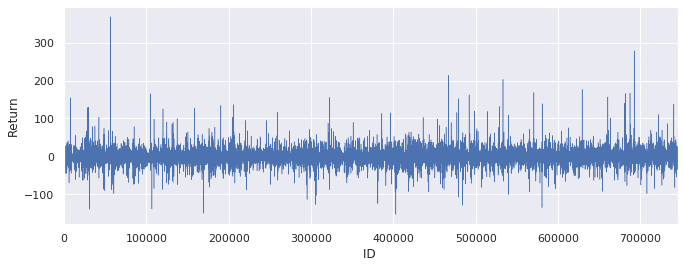

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})
df_input['09:30:00'].plot(linewidth=0.5)
plt.xlabel('ID ')
plt.ylabel('Return')

Text(0, 0.5, 'Return')

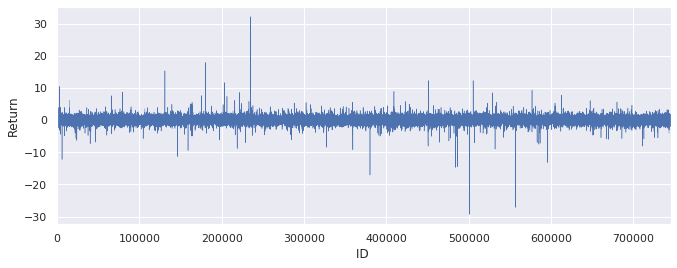

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})
df_input['12:30:00'].plot(linewidth=0.5)
plt.xlabel('ID ')
plt.ylabel('Return')

Text(0, 0.5, 'Return')

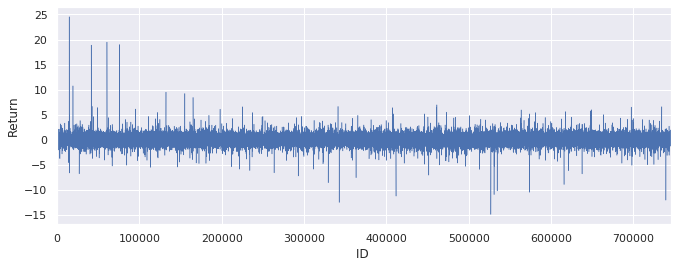

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})
df_input['15:20:00'].plot(linewidth=0.5)
plt.xlabel('ID ')
plt.ylabel('Return')

Analysis 

Return value is more deviating in opening time after that return is releatively Stable i.e (not deviating to much).

Beheaviour of an ID in complete training time.

In [ ]:
ts=df_input.loc[745300,'09:30:00':'15:20:00']
ts1=df_input.loc[745301,'09:30:00':'15:20:00']
ts2=df_input.loc[453020,'09:30:00':'15:20:00']
ts3=df_input.loc[210034,'09:30:00':'15:20:00']
ts4=df_input.loc[652891,'09:30:00':'15:20:00']
ts5=df_input.loc[400000,'09:30:00':'15:20:00']
ts6=df_input.loc[510000,'09:30:00':'15:20:00']
ts7=df_input.loc[2,'09:30:00':'15:20:00']
ts8=df_input.loc[0,'09:30:00':'15:20:00']

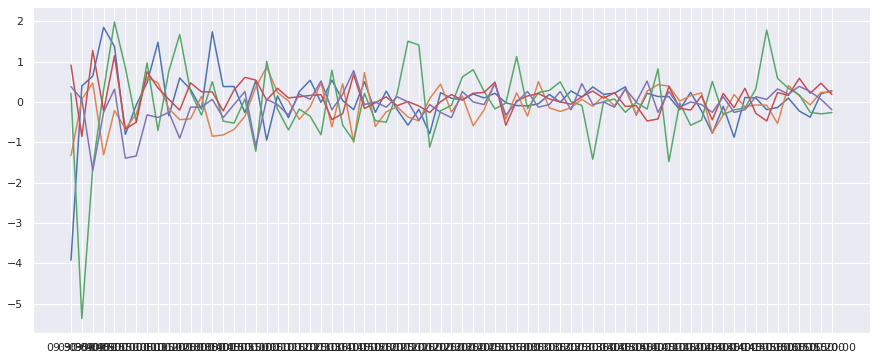

In [ ]:
rcParams['figure.figsize'] = 15,6
plt.plot(ts)
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)
plt.plot(ts8)
#plt.plot(ts4)
#plt.plot(ts5)
#plt.plot(ts6)
#plt.plot(ts7)

In [ ]:
tst=df_test.loc[2,'09:30:00':'15:20:00']
tst1=df_test.loc[200,'09:30:00':'15:20:00']
tst2=df_test.loc[3560,'09:30:00':'15:20:00']
tst3=df_test.loc[65000,'09:30:00':'15:20:00']
tst4=df_test.loc[142000,'09:30:00':'15:20:00']
tst5=df_test.loc[190000,'09:30:00':'15:20:00']
tst6=df_test.loc[319000,'09:30:00':'15:20:00']

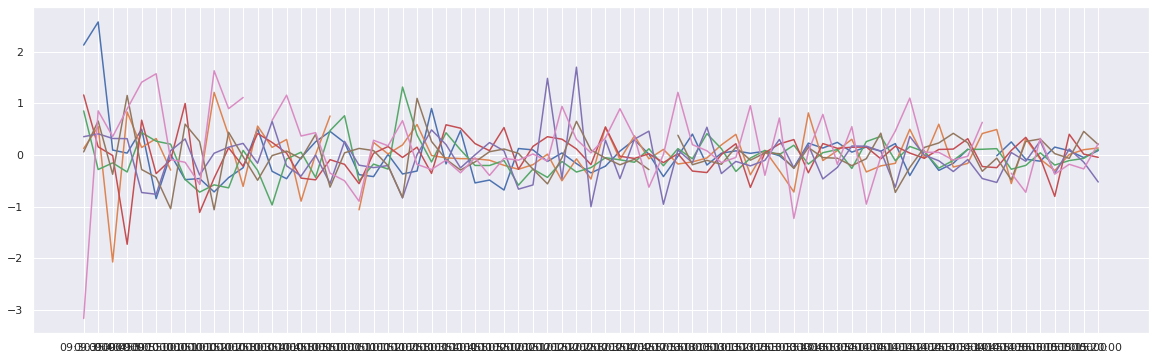

In [ ]:
rcParams['figure.figsize'] = 20,6
plt.plot(tst)
plt.plot(tst1)
plt.plot(tst2)
plt.plot(tst3)
plt.plot(tst4)
plt.plot(tst5)
plt.plot(tst6)

*Analysis*
Opening time returns are more flucuating after that return values are almost constant.

## **Pre processing**

Checking stationerity of data.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

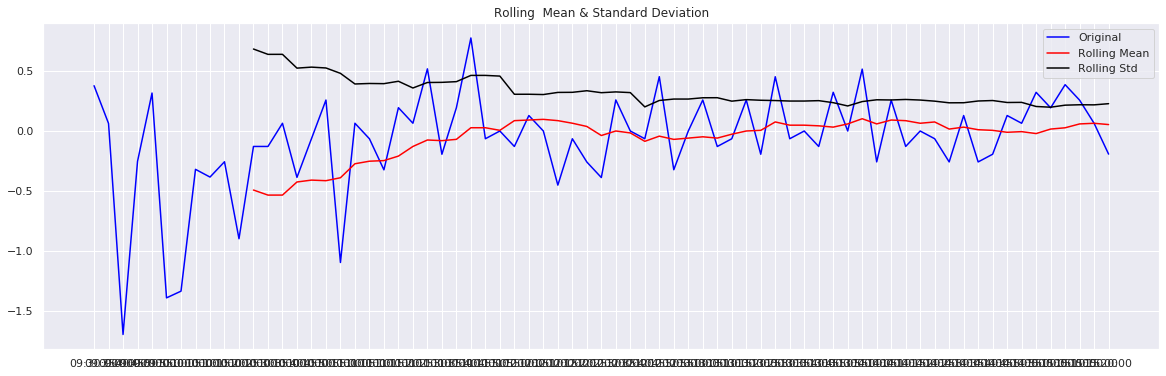

Results of Dickey-Fuller Test:
Test Statistic                 -3.021999
p-value                         0.032890
#Lags Used                      2.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [ ]:
test_stationarity(ts8)

**Observation**

As Test Statistic > Critical Value (1%) so the time series is stationary with 95% confidence.

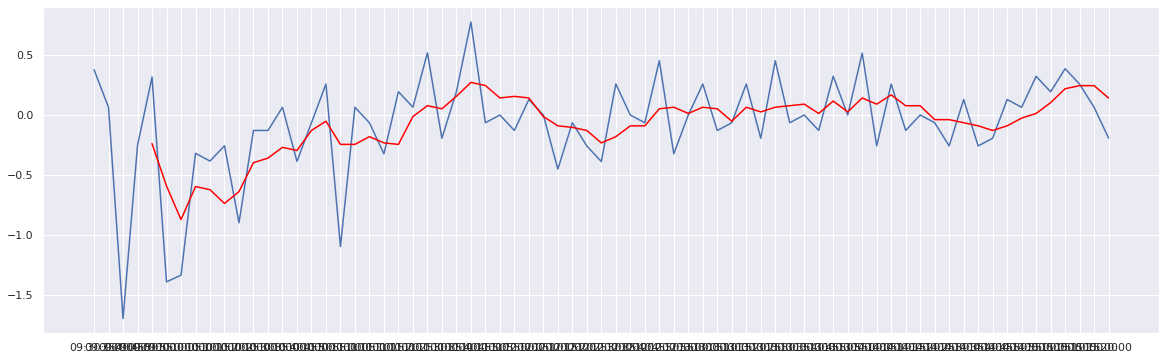

In [ ]:
moving_avg=ts8.rolling(5).mean()

plt.plot(ts8)
plt.plot(moving_avg,color='red')

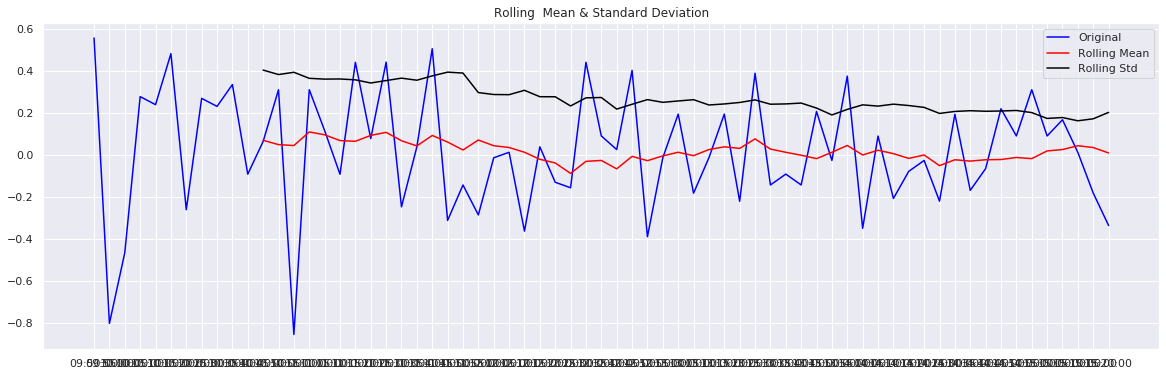

Results of Dickey-Fuller Test:
Test Statistic                 -3.894508
p-value                         0.002076
#Lags Used                      5.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [ ]:
ts8_moving_avg_diff=ts8-moving_avg
ts8_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts8_moving_avg_diff)

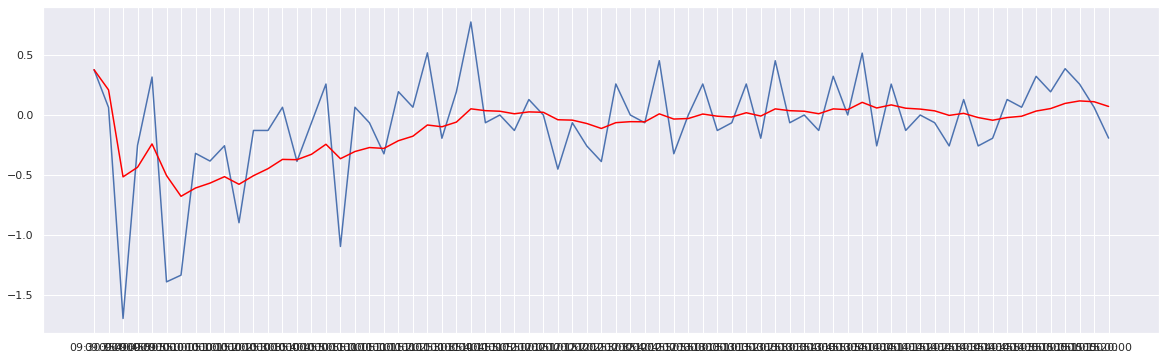

In [ ]:
exp_weighted_avg=ts8.ewm(halflife=5).mean()
plt.plot(ts8)
plt.plot(exp_weighted_avg,color='red')

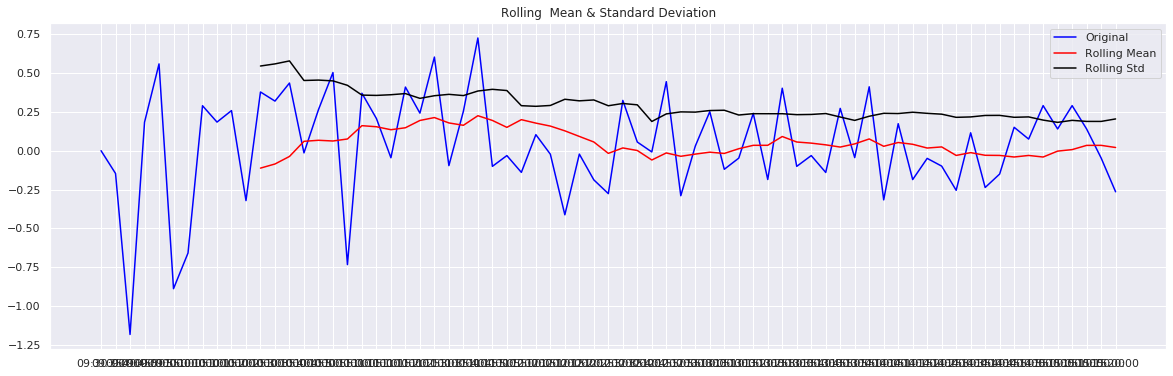

Results of Dickey-Fuller Test:
Test Statistic                 -4.823993
p-value                         0.000049
#Lags Used                      2.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [ ]:
ts8_ema_diff=ts8-exp_weighted_avg
test_stationarity(ts8_ema_diff)

The test statics is less than 1% critical value and p-value is less than 0.05 so, the time series is statonary.

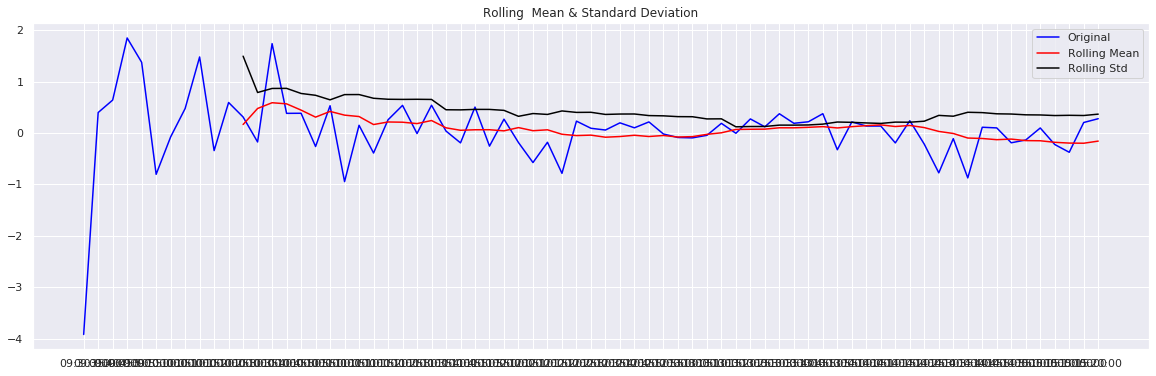

Results of Dickey-Fuller Test:
Test Statistic                -5.944681e+00
p-value                        2.218586e-07
#Lags Used                     1.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [ ]:
test_stationarity(ts)

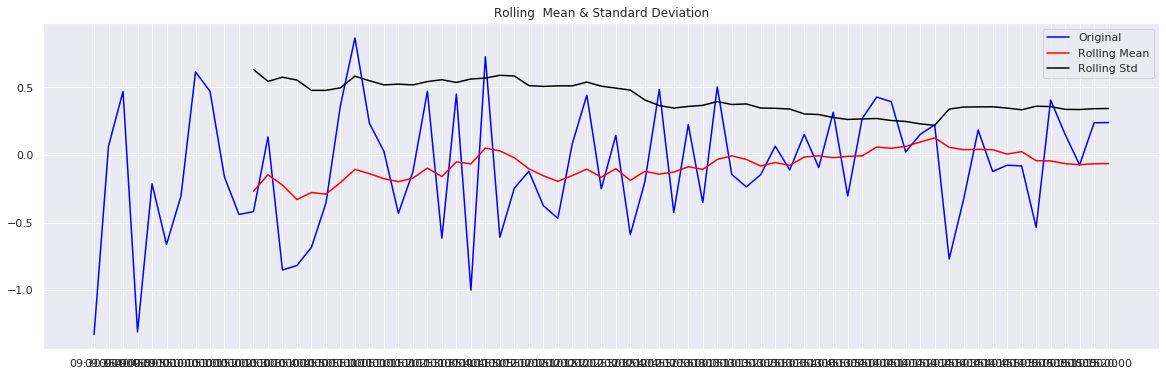

Results of Dickey-Fuller Test:
Test Statistic                -5.679353e+00
p-value                        8.557245e-07
#Lags Used                     1.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [ ]:
test_stationarity(ts1)

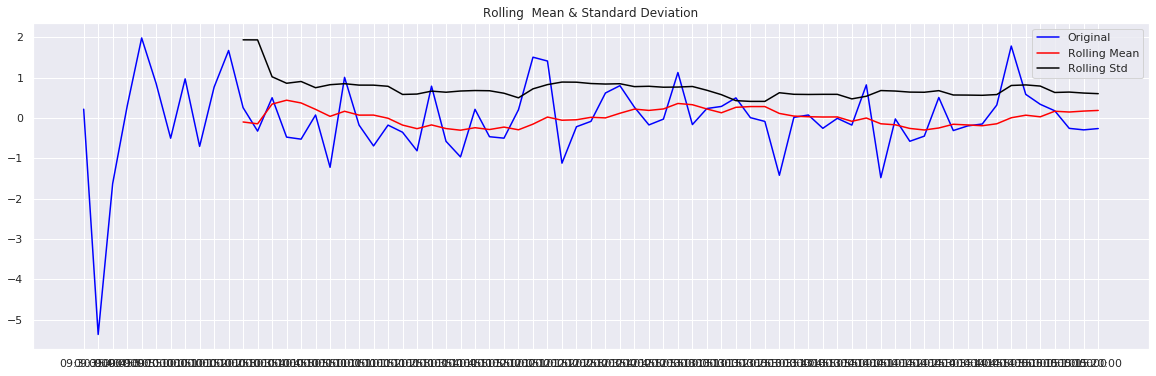

Results of Dickey-Fuller Test:
Test Statistic                -7.162107e+00
p-value                        2.949787e-10
#Lags Used                     0.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [ ]:
test_stationarity(ts2)

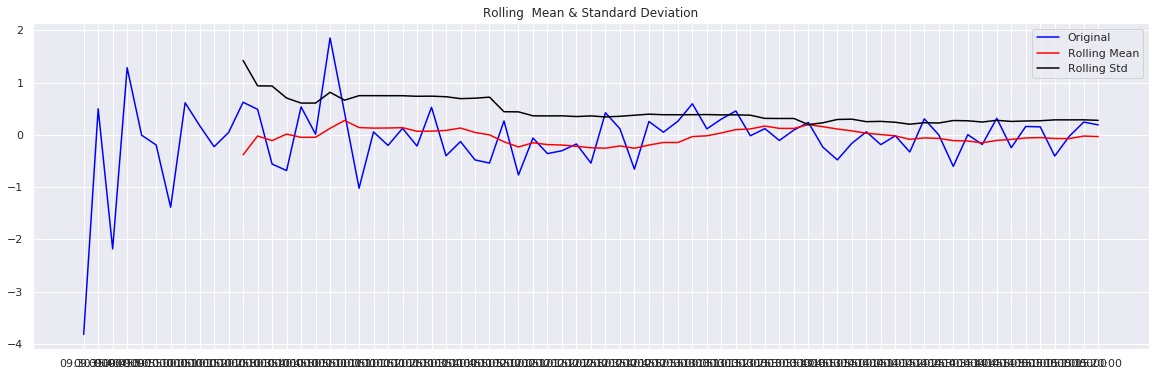

Results of Dickey-Fuller Test:
Test Statistic                -1.301142e+01
p-value                        2.563156e-24
#Lags Used                     0.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [ ]:
test_stationarity(ts4)

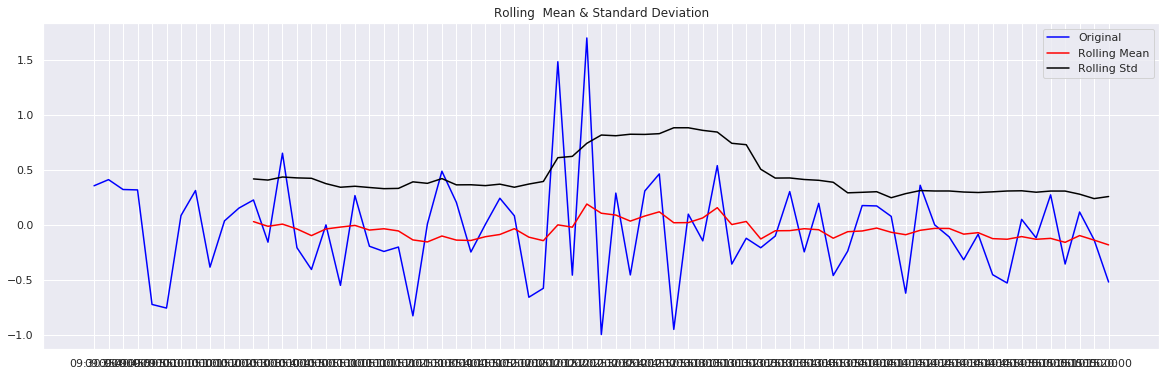

Results of Dickey-Fuller Test:
Test Statistic                -1.134888e+01
p-value                        1.010991e-20
#Lags Used                     0.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [ ]:
test_stationarity(tst4)

Filling missing values in training and testing data using linear interpolation.

In [ ]:
df_input=df_input.interpolate()
df_test=df_test.interpolate()

In [ ]:
df_input.describe()

ID      eqt_code  ...       15:15:00       15:20:00
count  745327.000000  7.453270e+05  ...  745327.000000  745327.000000
mean   372663.000000  2.096091e+09  ...      -0.000187       0.000324
std    215157.516379  1.253347e+09  ...       0.396428       0.396406
min         0.000000  3.667330e+06  ...     -15.165875     -14.854894
25%    186331.500000  1.047929e+09  ...      -0.210308      -0.211928
50%    372663.000000  2.002627e+09  ...      -0.001686      -0.001568
75%    558994.500000  3.195928e+09  ...       0.208615       0.209670
max    745326.000000  4.283129e+09  ...      28.411473      24.544605

[8 rows x 74 columns]

In [ ]:
df_test.describe()

ID      eqt_code  ...       15:15:00       15:20:00
count  3.197690e+05  3.197690e+05  ...  319769.000000  319769.000000
mean   9.052110e+05  2.095940e+09  ...      -0.000657       0.000984
std    9.230950e+04  1.252960e+09  ...       0.404789       0.391618
min    7.453270e+05  3.667330e+06  ...      -9.915366     -13.199368
25%    8.252690e+05  1.047929e+09  ...      -0.213210      -0.209571
50%    9.052110e+05  2.002627e+09  ...      -0.002121      -0.000630
75%    9.851530e+05  3.195928e+09  ...       0.210321       0.210188
max    1.065095e+06  4.283129e+09  ...      58.639122      17.585892

[8 rows x 74 columns]

Finding unique date in training data.

In [ ]:
dates = df_input['date'].unique()

Splitting data into training and testing data.

In [ ]:
dates_train = dates[0:]
dates_test = dates[1000:]

In [ ]:
df_input_train = df_input[df_input['date'].isin(dates_train)]
df_input_test = df_input[df_input['date'].isin(dates_test)]

Classifying output of train data to 0 and 1 based on return value.

In [ ]:
df_output['is_positive'] = df_output['end_of_day_return'].apply(lambda x: 1.0 if x > 0.5 else 0.0)

In [ ]:
df_output.head()

ID  end_of_day_return  is_positive
0   0           0.964025          1.0
1   1          -0.583286          0.0
2   2           2.191065          1.0
3   3           0.406176          0.0
4   4          -0.053764          0.0

Splitting output data in training and testing set based on train_date and test_date condition.

In [ ]:
df_output_train = df_output[df_output['ID'].isin(df_input_train['ID'])]
df_output_test = df_output[df_output['ID'].isin(df_input_test['ID'])]

Droping Id and date from training and testing data. 

In [ ]:
X_train = df_input_train.drop(['ID', 'date'], axis=1)
X_test = df_input_test.drop(['ID', 'date'], axis=1)

In [ ]:
df_test = df_test.drop(['ID', 'date'], axis=1)

In [ ]:
y_train = df_output_train['is_positive']
y_test = df_output_test['is_positive']

In [ ]:
X_train.shape

(745327, 72)

In [ ]:
X_test.shape

(250731, 72)

In [ ]:
y_train.shape

(745327,)

In [ ]:
y_test.shape

(250731,)

#**Training and model building**

In [ ]:
import time

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        print('\nAccuracy: ', accuracy_score(y_predict, model.predict(X_predict)))
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        print(rmse(y_test, model.predict(X_test)))
        scores.append(rmse(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [ ]:
prediction_times = []
training_times = []
scores = []

##Logistic Regression

In [ ]:
lr=Train(LogisticRegression(),X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training time: 
Execution Time: 00:00:05

Accuracy:  0.7357406942101296

Prediction time: 
Execution Time: 00:00:00


Accuracy score : 0.5014

#Random Forest

Parameter tuining using randomized search cv

In [ ]:
 params={
     'n_estimators': range(150,165),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [2, 4, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_split': [2, 3, 4, 5]
 }

In [ ]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
cv_rf = RandomizedSearchCV(
    RandomForestClassifier(bootstrap=False, random_state=42),
    params,
    n_iter=40, scoring=['accuracy', 'f1_micro'], random_state=42, n_jobs=-1, iid=True, refit='f1_micro'
)
cv_rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best fit model parameters value:-

n_estimators:158
  
max_depth: 8

 min_samples_split:4

In [ ]:
# Random Forests
rf = Train(RandomForestClassifier(n_jobs=-1, n_estimators=158, max_depth=8,min_sample_split=4), X_train, y_train, X_test, y_test)

Accuracy:0.5157

**Aaalysis**

Random forest uses bootstraping method for training and testing and it uses decision tree for predicting.Bootstrapping generates random samples from datasets without replacement.So,insteading updating new models based of previous errors.It simply take random samples and generatae the model due to this accuracy is low as compared to XGBoost for ur data set.

##LGMClassifier

In [ ]:
 params={
    'n_estimators': range(175,180),
    'n_leaves': range(31,35),
    'max_depth': [2, 4, 8, 10, 12, 14, 16, 18, 20]
     }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
cv_lgb = RandomizedSearchCV(
    LGBMClassifierr(bootstrap=False, random_state=42),
    params,
    n_iter=40, scoring=['accuracy', 'f1_micro'], random_state=42, n_jobs=-1, iid=True, refit='f1_micro'
)
cv_lgb.fit(X_train, y_train)

Best fit parameters:

n_estimators=175


n_leaves=32


max_depth=5

In [ ]:
# LightGBM
lgb = Train(LGBMClassifier(n_estimators=175, max_depth=5,n_leaves=32), X_train, y_train, X_test, y_test)

Accuracy:0.5187

In [ ]:
from sklearn.model_selection import learning_curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
y_pred=[]
y_pred=lgb.predict(df_test)

In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:
!head submission.csv

##Stacking

Taking logistic regression as metaClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf1 = RandomForestClassifier(n_jobs=-1, n_estimators=158, max_depth=5)
clf2 = XGBClassifier(n_estimators=150, max_depth=5)
clf3 = LGBMClassifier(n_estimators=150, max_depth=5)
sclf1 = Train(StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=LogisticRegression()), X_train, y_train, X_test, y_test)

Accuracy:0.5198

Taking DecisionTree regression as metaClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf1 = RandomForestClassifier(n_jobs=-1, n_estimators=158, max_depth=5)
clf2 = XGBClassifier(n_estimators=150, max_depth=5)
clf3 = LGBMClassifier(n_estimators=150, max_depth=5)
sclf1 = Train(StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=DecisionTreeClassifier()), X_train, y_train, X_test, y_test)

Accuracy:0.5225

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes,train_scores,test_scores=learning_curve(RandomForestClassifier(),X_train,y_train,cv=10,scoring='accuracy',n_jobs=-1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,'--',color='#111111',label='Training score')
plt.plot(train_sizes,train_mean,color='#111111',label='cross-validation score')

plt.fill_between(train_sizes,test_mean - test_std,test_mean + test_std,color='#DDDDDD')

In [ ]:
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model.predict(X_test)

In [ ]:
print(classification_report(y_test,model.predict_classes(X_test.values)))

#Prediction

In [ ]:
y_pred=[]
y_pred=model.predict(df_test)

#Submission File

In [ ]:
my_submission = pd.DataFrame(data=y_pred, index=df_test1.ID)

In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:
pwd

In [ ]:
my_submission.head()

In [ ]:
!head submission.csv